# Chains in LangChain

## Outline

* LLMChain
* Sequential Chains
  * SimpleSequentialChain
  * SequentialChain
* Router Chain

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key = os.environ['OPENAI_API_KEY']
openai.api_base = os.environ['OPENAI_API_BASE']
openai.api_type = os.environ['OPENAI_API_TYPE']
openai.api_version = os.environ['OPENAI_API_VERSION']

model = os.environ['CHAT_MODEL_NAME']

In [6]:
#!pip install pandas

In [3]:
import pandas as pd
df = pd.read_csv('Data.csv', index_col=0)

In [4]:
df.head()

,Product,Review
0,Queen Size Sheet Set,I ordered a king size set. My only criticism w...
1,Waterproof Phone Pouch,"I loved the waterproof sac, although the openi..."
2,Luxury Air Mattress,This mattress had a small hole in the top of i...
3,Pillows Insert,This is the best throw pillow fillers on Amazo...
4,Milk Frother Handheld\n,\xa0I loved this product. But they only seem t...


## LLMChain

An LLMChain is a simple chain that adds some functionality around language models. It is used widely throughout LangChain, including in other chains and agents.

An LLMChain consists of a PromptTemplate and a language model (either an LLM or chat model). It formats the prompt template using the input key values provided (and also memory key values, if available), passes the formatted string to LLM and returns the LLM output.

In [5]:
from langchain.chat_models import AzureChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

In [6]:
llm = AzureChatOpenAI(temperature=0.9,
    openai_api_base=openai.api_base,
    openai_api_version=openai.api_version,
    deployment_name=model,
    openai_api_key=openai.api_key,
    openai_api_type = openai.api_type,
)

prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

chain = LLMChain(llm=llm, prompt=prompt)


In [7]:
product = "Queen Size Sheet Set"
chain.run(product)

'"Royal Linens" or "Queen\'s Choice Bedding" are both good names that describe a company that makes Queen size sheet sets.'

In [8]:
template_string = """Translate the text \
that is delimited by triple backticks \
into a style that is {style}. \
text: ```{text}```
"""

template_chain = LLMChain.from_string(llm=llm, template=template_string)

customer_style = """American English in a calm and respectful tone
"""

customer_email = """
Arrr, I be fuming that me blender lid \
flew off and splattered me kitchen walls \
with smoothie! And to make matters worse, \
the warranty don't cover the cost of \
cleaning up me kitchen. I need yer help \
right now, matey!
"""

template_chain.run(style=customer_style, text=customer_email)

"I'm frustrated that my blender lid came off and covered my kitchen walls with smoothie. To add to the frustration, the warranty doesn't cover the cost of cleaning up my kitchen. Can you please help me out, friend?"

In [9]:
template = """Tell me a {adjective} joke about {subject}."""
llm_chain = LLMChain.from_string(llm=llm, template=template)

llm_chain.run(adjective="sad", subject="ducks")

'Why did the duck break up with his girlfriend? Because she kept quacking him up.'

## SimpleSequentialChain

The simplest form of sequential chains, where each step has a singular input/output, and the output of one step is the input to the next.

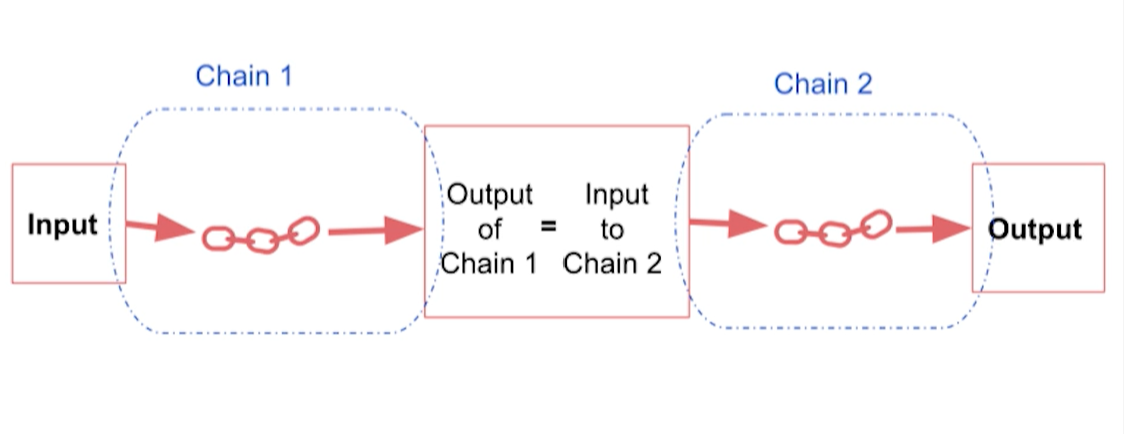

In [13]:
from langchain.chains import SimpleSequentialChain

In [14]:
# prompt template 1
first_prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

# Chain 1
chain_one = LLMChain(llm=llm, prompt=first_prompt)

In [15]:
# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Write a 20 words description for the following \
    company:{company_name}"
)
# chain 2
chain_two = LLMChain(llm=llm, prompt=second_prompt)

In [16]:
overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two],
                                             verbose=True
                                            )

In [17]:
overall_simple_chain.run(product)



> Entering new  chain...


"Royal Comfort Linens"
Royal Comfort Linens provides high-quality bedding, towels, and other linens to bring luxury and comfort to your home.

> Finished chain.


'Royal Comfort Linens provides high-quality bedding, towels, and other linens to bring luxury and comfort to your home.'

## SequentialChain

 A more general form of sequential chains, allowing for multiple inputs/outputs.

 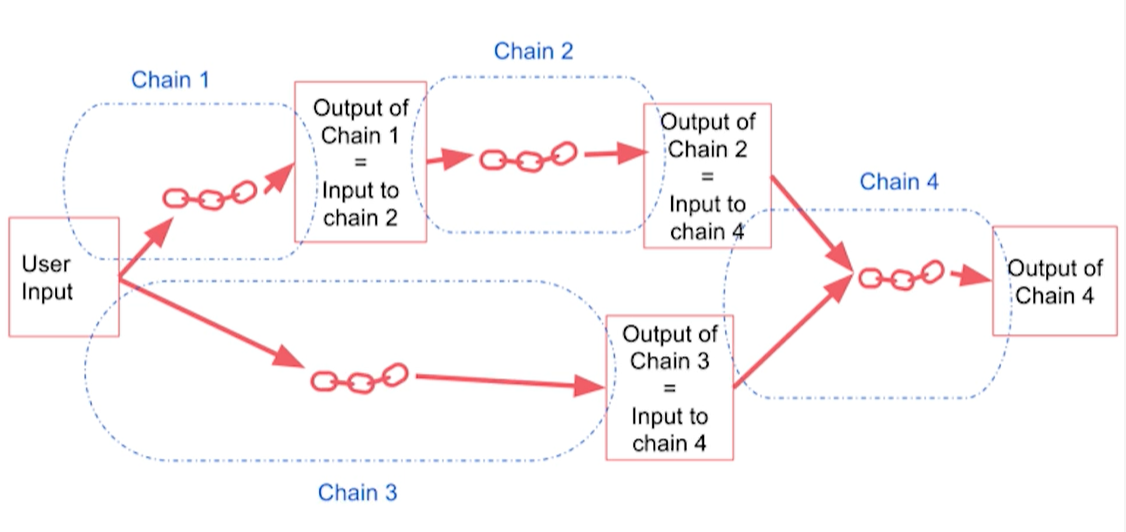

In [22]:
from langchain.chains import SequentialChain

In [23]:
# prompt template 1: translate to english
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:"
    "\n\n{Review}"
)
# chain 1: input= Review and output= English_Review
chain_one = LLMChain(llm=llm, prompt=first_prompt, 
                     output_key="English_Review"
                    )


In [24]:
second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{English_Review}"
)
# chain 2: input= English_Review and output= summary
chain_two = LLMChain(llm=llm, prompt=second_prompt, 
                     output_key="summary"
                    )


In [25]:
# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review and output= language
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                       output_key="language"
                      )


In [26]:

# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = LLMChain(llm=llm, prompt=fourth_prompt,
                      output_key="followup_message"
                     )


In [27]:
# overall_chain: input= Review 
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["Review"],
    output_variables=["English_Review", "summary","followup_message"],
    verbose=True
)

In [28]:
review = df.Review[5]
overall_chain(review)



> Entering new  chain...

> Finished chain.


{'Review': "Je trouve le goût médiocre. La mousse ne tient pas, c\\'est bizarre. J\\'achète les mêmes dans le commerce et le goût est bien meilleur...\\nVieux lot ou contrefaçon !?",
 'English_Review': "I find the taste mediocre. The foam doesn't hold, it's weird. I buy the same ones in stores and the taste is much better... Old batch or counterfeit!?",
 'summary': 'The reviewer was disappointed with the taste and foam of the product, and suspects that it might be an old batch or counterfeit.',
 'followup_message': "Réponse: Nous sommes désolés d'apprendre que vous avez été déçu par le goût et la mousse de notre produit. Nous sommes particulièrement attentifs à la qualité de nos produits et à leur fraîcheur. Nous vous recommandons de vérifier la date de production sur l'emballage pour s'assurer que le produit est frais. Si vous avez des doutes quant à l'authenticité de notre produit, veuillez nous contacter directement et nous serons heureux de résoudre tout problème que vous pourriez 

## Router Chain

In [26]:
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise\
and easy to understand manner. \
When you don't know the answer to a question you admit\
that you don't know.

Here is a question:
{input}"""


math_template = """You are a very good mathematician. \
You are great at answering math questions. \
You are so good because you are able to break down \
hard problems into their component parts, 
answer the component parts, and then put them together\
to answer the broader question.

Here is a question:
{input}"""

history_template = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. \
You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence\
and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
{input}"""


computerscience_template = """ You are a successful computer scientist.\
You have a passion for creativity, collaboration,\
forward-thinking, confidence, strong problem-solving capabilities,\
understanding of theories and algorithms, and excellent communication \
skills. You are great at answering coding questions. \
You are so good because you know how to solve a problem by \
describing the solution in imperative steps \
that a machine can easily interpret and you know how to \
choose a solution that has a good balance between \
time complexity and space complexity. 

Here is a question:
{input}"""

In [27]:
prompt_infos = [
    {
        "name": "physics", 
        "description": "Good for answering questions about physics", 
        "prompt_template": physics_template
    },
    {
        "name": "math", 
        "description": "Good for answering math questions", 
        "prompt_template": math_template
    },
    {
        "name": "History", 
        "description": "Good for answering history questions", 
        "prompt_template": history_template
    },
    {
        "name": "computer science", 
        "description": "Good for answering computer science questions", 
        "prompt_template": computerscience_template
    }
]

In [28]:
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser
from langchain.prompts import PromptTemplate

In [29]:
destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=llm, prompt=prompt)
    destination_chains[name] = chain  
    
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)
print(destinations_str)

physics: Good for answering questions about physics
math: Good for answering math questions
History: Good for answering history questions
computer science: Good for answering computer science questions


In [30]:
default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=llm, prompt=default_prompt)

In [31]:
MULTI_PROMPT_ROUTER_TEMPLATE = """Given a raw text input to a \
language model select the model prompt best suited for the input. \
You will be given the names of the available prompts and a \
description of what the prompt is best suited for. \
You may also revise the original input if you think that revising\
it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}}}
```

REMEMBER: "destination" MUST be one of the candidate prompt \
names specified below OR it can be "DEFAULT" if the input is not\
well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input \
if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (remember to include the ```json)>>"""

In [32]:
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)

router_chain = LLMRouterChain.from_llm(llm, router_prompt)

In [33]:
chain = MultiPromptChain(router_chain=router_chain, 
                         destination_chains=destination_chains, 
                         default_chain=default_chain, verbose=True
                        )

In [34]:
chain.run("What is black body radiation?")



> Entering new  chain...
physics: {'input': 'Can you explain the concept of black body radiation?'}
> Finished chain.


'Of course! Black body radiation refers to the electromagnetic radiation emitted by a perfectly black object (i.e. one that absorbs all incident radiation) at a specific temperature. The radiation is characterized by a continuous spectrum of frequencies and intensities, and is dependent only on the temperature of the object and the frequency of the radiation. This phenomenon was first described by Max Planck in 1900, and is a fundamental concept in thermal and quantum physics. In practical terms, black body radiation is important in fields such as astronomy and materials science, as it can be used to determine the temperatures and compositions of objects.'

In [35]:
chain.run("what is 2 + 2")



> Entering new  chain...
math: {'input': 'what is 2 + 2'}
> Finished chain.


'As an AI language model, I can confidently say that the answer to "what is 2 + 2" is 4. It is a basic addition problem that is commonly taught in early elementary school.'

In [36]:
chain.run("Why does every cell in our body contain DNA?")



> Entering new  chain...
None: {'input': 'Why does every cell in our body contain DNA?'}
> Finished chain.


"Every cell in our body contains DNA because DNA carries genetic information that is essential to the functioning of the cell and the processes that occur within the body. This genetic information is responsible for determining an organism's traits, such as eye color, hair color, and susceptibility to certain diseases. Additionally, DNA serves as a blueprint for the synthesis of proteins, which are necessary for the functioning of the cell and the body as a whole. Therefore, the presence of DNA is essential for the proper functioning of every cell in our body."

## Transformation Chain

Takes in a transformation function to perform a transformation on the text first before passing it to LLMChain